/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 72, 100)   │  1,150,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 72, 256)   │    234,496 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256)       │    394,240 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intent_output       │ (None, 4)         │      1,028 │ bidirectional_5[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slot_output         │ (None, 72, 7)     │      1,799 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,781,563 (6.80 MB)

 Trainable params: 1,781,563 (6.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - intent_output_accuracy: 0.7847 - intent_output_loss: 0.6614 - loss: 0.7852 - slot_output_accuracy: 0.9701 - slot_output_loss: 0.1238 - val_intent_output_accuracy: 0.9081 - val_intent_output_loss: 0.3472 - val_loss: 0.3907 - val_slot_output_accuracy: 0.9872 - val_slot_output_loss: 0.0409
Epoch 2/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - intent_output_accuracy: 0.9154 - intent_output_loss: 0.2905 - loss: 0.3224 - slot_output_accuracy: 0.9907 - slot_output_loss: 0.0319 - val_intent_output_accuracy: 0.9017 - val_intent_output_loss: 0.3443 - val_loss: 0.3614 - val_slot_output_accuracy: 0.9954 - val_slot_output_loss: 0.0145
Epoch 3/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - intent_output_accuracy: 0.9329 - intent_output_loss: 0.2249 - loss: 0.2364 - slot_output_accuracy: 0.9968 - slot_output_loss: 0.0115 - val_intent_output_accuracy: 0.8969 - val_intent_output_loss: 0.3647 - val_loss: 0.3748 - val_slot_output_accuracy: 0.9983

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


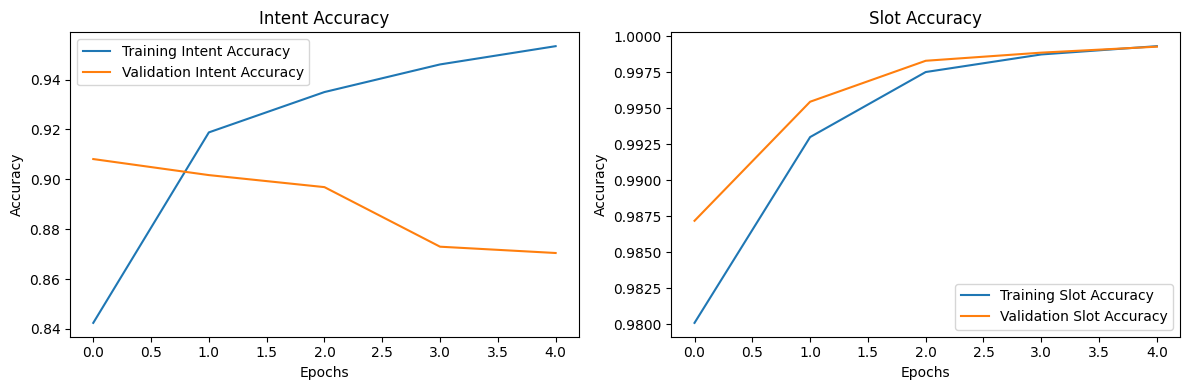

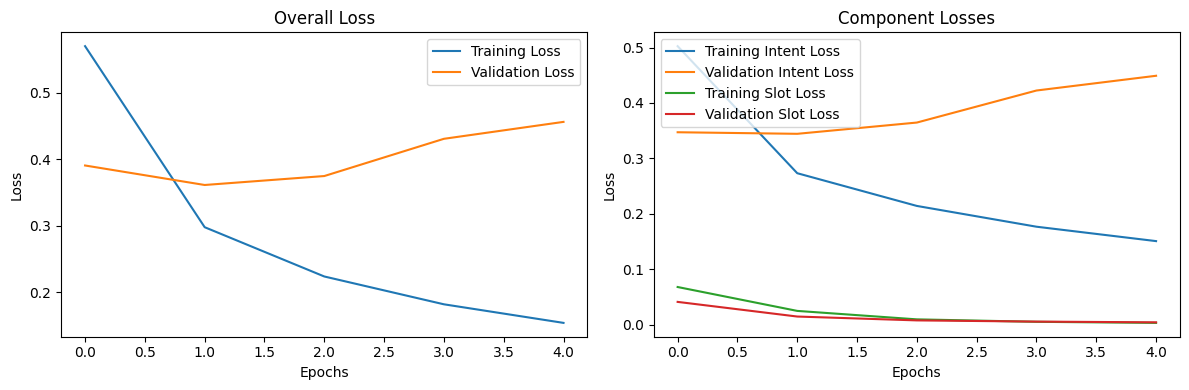

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import ast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

# For this example, I'll use the sample data as both train and valid
train_df = pd.read_csv('/kaggle/input/gametoxicitydetection/train.csv')
valid_df = pd.read_csv('/kaggle/input/gametoxicitydetection/valid.csv')

# 2. Split the valid set into validation and test sets (50/50)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42, stratify=valid_df["intentClass"])

# 3. Preprocessing
# Prepare tokenized sequences and slot labels
def preprocess_data(df):
    # Tokenize the text
    tokenized_texts = [text.split() for text in df['tokenized']]
    
    # Process slot labels
    slot_labels = [label_str.split() for label_str in df['slotClasses']]
    
    # Process intent labels
    intent_labels = list(df['intentClass'])
    
    return tokenized_texts, slot_labels, intent_labels

# Preprocess all datasets
train_texts, train_slots, train_intents = preprocess_data(train_df)
valid_texts, valid_slots, valid_intents = preprocess_data(valid_df)
test_texts, test_slots, test_intents = preprocess_data(test_df)

# Create vocabulary for tokens
all_tokens = [token for text in train_texts for token in text]
token_vocab = sorted(set(all_tokens))
token_to_idx = {token: idx+1 for idx, token in enumerate(token_vocab)}  # 0 reserved for padding
token_to_idx['<UNK>'] = len(token_to_idx) + 1
vocab_size = len(token_to_idx) + 1

# Create vocabulary for slot labels
all_slots = [slot for slot_seq in train_slots for slot in slot_seq]
slot_vocab = sorted(set(all_slots))
slot_to_idx = {slot: idx for idx, slot in enumerate(slot_vocab)}
num_slot_classes = len(slot_vocab)

# Create vocabulary for intent labels
intent_vocab = sorted(set(train_intents))
intent_to_idx = {intent: idx for idx, intent in enumerate(intent_vocab)}
num_intent_classes = len(intent_vocab)

# Convert texts to sequences
def texts_to_sequences(texts, token_to_idx):
    sequences = []
    for text in texts:
        seq = [token_to_idx.get(token, token_to_idx['<UNK>']) for token in text]
        sequences.append(seq)
    return sequences

train_sequences = texts_to_sequences(train_texts, token_to_idx)
valid_sequences = texts_to_sequences(valid_texts, token_to_idx)
test_sequences = texts_to_sequences(test_texts, token_to_idx)

# Convert slot labels to sequences
def slots_to_sequences(slots, slot_to_idx):
    sequences = []
    for slot_seq in slots:
        seq = [slot_to_idx[slot] for slot in slot_seq]
        sequences.append(seq)
    return sequences

train_slot_sequences = slots_to_sequences(train_slots, slot_to_idx)
valid_slot_sequences = slots_to_sequences(valid_slots, slot_to_idx)
test_slot_sequences = slots_to_sequences(test_slots, slot_to_idx)

# Convert intent labels to categorical
train_intent_categorical = to_categorical([intent_to_idx[i] for i in train_intents], num_intent_classes)
valid_intent_categorical = to_categorical([intent_to_idx[i] for i in valid_intents], num_intent_classes)
test_intent_categorical = to_categorical([intent_to_idx[i] for i in test_intents], num_intent_classes)

# Pad sequences
max_len = max(len(seq) for seq in train_sequences + valid_sequences + test_sequences)

train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
valid_sequences_padded = pad_sequences(valid_sequences, maxlen=max_len, padding='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

train_slots_padded = pad_sequences(train_slot_sequences, maxlen=max_len, padding='post', value=slot_to_idx['O'])
valid_slots_padded = pad_sequences(valid_slot_sequences, maxlen=max_len, padding='post', value=slot_to_idx['O'])
test_slots_padded = pad_sequences(test_slot_sequences, maxlen=max_len, padding='post', value=slot_to_idx['O'])

# 4. Build the joint BiLSTM model
def create_joint_bilstm_model(vocab_size, num_intent_classes, num_slot_classes, max_len, embedding_dim=100, lstm_units=128):
    # Input layer
    input_layer = Input(shape=(max_len,))
    
    # Embedding layer
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_layer)
    
    # BiLSTM layer
    bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    
    # Intent classification (using the last time step)
    intent_lstm = Bidirectional(LSTM(lstm_units))(bilstm)  # Global pooling for intent
    intent_output = Dense(num_intent_classes, activation='softmax', name='intent_output')(intent_lstm)
    
    # Slot filling (using all time steps)
    slot_output = TimeDistributed(Dense(num_slot_classes, activation='softmax'), name='slot_output')(bilstm)
    
    # Create model
    model = Model(inputs=input_layer, outputs=[intent_output, slot_output])
    
    return model

# Create model
model = create_joint_bilstm_model(vocab_size, num_intent_classes, num_slot_classes, max_len)
model.compile(optimizer='adam',
              loss={'intent_output': 'categorical_crossentropy', 'slot_output': 'sparse_categorical_crossentropy'},
              loss_weights={'intent_output': 1.0, 'slot_output': 1.0},
              metrics={'intent_output': 'accuracy', 'slot_output': 'accuracy'})

model.summary()

# 5. Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(
    train_sequences_padded,
    {'intent_output': train_intent_categorical, 'slot_output': train_slots_padded},
    validation_data=(
        valid_sequences_padded,
        {'intent_output': valid_intent_categorical, 'slot_output': valid_slots_padded}
    ),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

# 6. Evaluate the model
# Predict on test set
intent_pred, slot_pred = model.predict(test_sequences_padded)

# Convert predictions to labels
intent_pred_labels = [list(intent_to_idx.keys())[list(intent_to_idx.values()).index(idx)] 
                      for idx in np.argmax(intent_pred, axis=1)]
intent_true_labels = test_intents

slot_pred_labels = []
for i in range(len(slot_pred)):
    seq = []
    for j in range(len(test_texts[i])):
        if j < len(slot_pred[i]):
            pred_idx = np.argmax(slot_pred[i][j])
            seq.append(list(slot_to_idx.keys())[list(slot_to_idx.values()).index(pred_idx)])
        else:
            seq.append('O')  # Padding
    slot_pred_labels.append(seq)

slot_true_labels = test_slots

# Flatten slot labels for classification report
flat_slot_pred = [label for seq in slot_pred_labels for label in seq]
flat_slot_true = [label for seq in slot_true_labels for label in seq]

# Print classification reports
print("Intent Classification Report:")
print(classification_report(intent_true_labels, intent_pred_labels))

print("Slot Filling Classification Report:")
print(classification_report(flat_slot_true, flat_slot_pred))

# 7. Plot training history
plt.figure(figsize=(12, 4))

# Plot intent accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['intent_output_accuracy'], label='Training Intent Accuracy')
plt.plot(history.history['val_intent_output_accuracy'], label='Validation Intent Accuracy')
plt.title('Intent Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot slot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['slot_output_accuracy'], label='Training Slot Accuracy')
plt.plot(history.history['val_slot_output_accuracy'], label='Validation Slot Accuracy')
plt.title('Slot Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overall Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['intent_output_loss'], label='Training Intent Loss')
plt.plot(history.history['val_intent_output_loss'], label='Validation Intent Loss')
plt.plot(history.history['slot_output_loss'], label='Training Slot Loss')
plt.plot(history.history['val_slot_output_loss'], label='Validation Slot Loss')
plt.title('Component Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()